# **BioPred Phase 1 Feature Engineering**

In this portion of the project, we will look to:

1. Take our notebook from our EDA phase and edit it, creating new features using the power of RDKit.

2. Encode our canonical_smiles feature using Morgan Fingerprints so they are able to be read as numerical, and so we can then use them in our models.

3. Take our categorical features and encode them separately, using One-Hot or similar so they are represented appropriately in the dataframe.

#### First as we have done in other notebooks let's import our libraries and read in our current eda_df file, saving it to another variable so we can work on it without deviating from the original data file still in progress.

In [2]:
# List libraries needed for this notebook.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, GraphDescriptors, AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.DataStructs import BitVectToText
from sklearn.neighbors import KDTree
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
# Establish file path to read in eda_df for usage here.
file_path = "/home/azureuser/cloudfiles/code/Users/kalpha1865/BioPred/Data/df_files/eda_1_phase_1.parquet"
fe_df = pd.read_parquet(file_path)

print(fe_df.shape)
fe_df.head()

(343659, 13)


,canonical_smiles,full_mwt,alogp,psa,hba_lipinski,hbd_lipinski,aromatic_rings,heavy_atoms,rtb,molecular_species,min_standard_value,activity_count,tid
0,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,317.18,4.50,26.30,2,0,2,19,1,NEUTRAL,4.615121,1.098612,11934
1,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,364.18,4.54,26.30,2,0,2,19,1,NEUTRAL,3.433987,0.693147,11934
2,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,262.31,3.78,26.30,2,0,2,20,1,NEUTRAL,4.564348,0.693147,11934
3,COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2...,433.51,2.68,93.81,8,2,3,32,5,NEUTRAL,0.412110,0.693147,104304
4,COc1cc2nc(N3CCN(S(=O)(=O)c4cccs4)CC3)nc(N)c2cc1OC,435.53,1.80,110.88,9,2,3,29,5,NEUTRAL,3.551914,0.693147,104304


#### So we will now look to expand our features using RDKit.  It comes with some built-in features we can use with our canonical_smiles data to enhance our dataset, providing new looks into our data.  We will then go back to our EDA ntbk with this and examine how this effects our data and our target. 

#### A lot of the features we already have in our current dataframe were provided by RDKit originally, so it is a matter of obtaining ones to be complementary to our goals.  Let's take a look at some of the features that can be added:

**Molecular Complexity (BertzCT, BalabanJ)**:
Complexity often correlates with unique molecular interactions.

**Shape Descriptors (FractionCSP3, Kappa Indices)**:
Shape and symmetry are linked to drug-likeness.

**Surface Area (LabuteASA)**:
Surface area impacts molecular accessbility to biological targets.

**HallKierAlpha**:
Measures molecular branching, often correlating with structural diversity and bioactivity.

**PEOE_VSA**:
Key for understanding electrostatic interactions.

**Kappa1, Kappa2, Kappa3**:
Quantify molecular shape and symmetry.

**ChiX indices (Chi0, Chi1)**:
Molecular connectivity indices for structural diversity.


#### Ok now let's write the function that uses our canonical_smiles feature and calculates the new features that we want to use from the RDKit library.

In [4]:
def rdkit_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return {}
    return {
        # Features for Structural Complexity
        "bertz_ct" : GraphDescriptors.BertzCT(mol),
        "hallkier_alpha" : Descriptors.HallKierAlpha(mol),
        "balaban_j" : Descriptors.BalabanJ(mol),
        
        # Features for Shape
        "fraction_csp3" : Descriptors.FractionCSP3(mol),
        
        # Features for Surface Area
        "labute_asa" : Descriptors.LabuteASA(mol),
        "peoe_vsa1" : Descriptors.PEOE_VSA1(mol),
        "peoe_vsa2" : Descriptors.PEOE_VSA2(mol),
        
        # Features for Connectivity and Topology
        "kappa1" : Descriptors.Kappa1(mol),
        "kappa2" : Descriptors.Kappa2(mol),
        "kappa3" : Descriptors.Kappa3(mol),
        "chi0" : Descriptors.Chi0(mol),
        "chi1" : Descriptors.Chi1(mol)
    }

# Now apply to our dataset.
fe_df['rdkit_feats'] = fe_df['canonical_smiles'].apply(rdkit_features)
rdkit_feats_df = pd.DataFrame(fe_df['rdkit_feats'].tolist())
fe_df = pd.concat([fe_df, rdkit_feats_df], axis = 1)
fe_df.drop(columns = ['rdkit_feats'], inplace = True)

fe_df.head()

,canonical_smiles,full_mwt,alogp,psa,hba_lipinski,hbd_lipinski,aromatic_rings,heavy_atoms,rtb,molecular_species,...,balaban_j,fraction_csp3,labute_asa,peoe_vsa1,peoe_vsa2,kappa1,kappa2,kappa3,chi0,chi1
0,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,317.18,4.50,26.30,2,0,2,19,1,NEUTRAL,...,2.032678,0.187500,119.749901,4.736863,4.794537,12.425157,5.174545,2.302843,13.242276,9.292025
1,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,364.18,4.54,26.30,2,0,2,19,1,NEUTRAL,...,2.032678,0.187500,125.144192,4.736863,4.794537,12.662582,5.327835,2.388698,13.242276,9.292025
2,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,262.31,3.78,26.30,2,0,2,20,1,NEUTRAL,...,1.988982,0.166667,117.611463,4.736863,4.794537,12.501099,5.223444,2.188684,13.949383,9.792025
3,COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2...,433.51,2.68,93.81,8,2,3,32,5,NEUTRAL,...,1.273158,0.375000,186.495387,25.007213,4.794537,20.358115,8.180995,3.656405,22.241912,15.584050
4,COc1cc2nc(N3CCN(S(=O)(=O)c4cccs4)CC3)nc(N)c2cc1OC,435.53,1.80,110.88,9,2,3,29,5,NEUTRAL,...,1.582585,0.333333,172.281067,20.107303,0.000000,19.676288,7.653369,3.561938,20.595647,13.934220


#### Great now before we analyze our new data and format it let's encode our SMILES strings into Morgan fingerprints.  For reference, this converts the canonical_smiles strings into machine-readable (read numerical) format for modeling.

In [5]:
# function to encode the morgan fingerprints, return empty array for invalid smiles data.

# Initialize the Morgan Generator
morgan_gen = GetMorganGenerator(radius = 2, fpSize = 2048) # for radius and bit size

def encode_smiles_to_prints(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None # Return None instead of an empty list
    return morgan_gen.GetFingerprint(mol) # Keep as RDKit fingerprint

# Similar process now for how we just did for the feature creation.
fe_df['morgan_fingerprints'] = fe_df['canonical_smiles'].apply(encode_smiles_to_prints)

# Check type to confirm
print(type(fe_df['morgan_fingerprints'].iloc[0]))

fe_df.head()

<class 'rdkit.DataStructs.cDataStructs.ExplicitBitVect'>


,canonical_smiles,full_mwt,alogp,psa,hba_lipinski,hbd_lipinski,aromatic_rings,heavy_atoms,rtb,molecular_species,...,fraction_csp3,labute_asa,peoe_vsa1,peoe_vsa2,kappa1,kappa2,kappa3,chi0,chi1,morgan_fingerprints
0,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,317.18,4.50,26.30,2,0,2,19,1,NEUTRAL,...,0.187500,119.749901,4.736863,4.794537,12.425157,5.174545,2.302843,13.242276,9.292025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,364.18,4.54,26.30,2,0,2,19,1,NEUTRAL,...,0.187500,125.144192,4.736863,4.794537,12.662582,5.327835,2.388698,13.242276,9.292025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,262.31,3.78,26.30,2,0,2,20,1,NEUTRAL,...,0.166667,117.611463,4.736863,4.794537,12.501099,5.223444,2.188684,13.949383,9.792025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2...,433.51,2.68,93.81,8,2,3,32,5,NEUTRAL,...,0.375000,186.495387,25.007213,4.794537,20.358115,8.180995,3.656405,22.241912,15.584050,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,COc1cc2nc(N3CCN(S(=O)(=O)c4cccs4)CC3)nc(N)c2cc1OC,435.53,1.80,110.88,9,2,3,29,5,NEUTRAL,...,0.333333,172.281067,20.107303,0.000000,19.676288,7.653369,3.561938,20.595647,13.934220,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


#### We will need these raw fingerprints in the next stage, lets save them as a couple of variables.

In [6]:
raw_fps = fe_df['morgan_fingerprints'].tolist()

print(type(raw_fps[0]))


<class 'rdkit.DataStructs.cDataStructs.ExplicitBitVect'>


#### Now a quick step we will do is make all of our new fingerprints into NumPy arrays.  This helps us utilize them in PCA (if needed) and our modeling.

In [7]:
# Convert the morgan_fingerprints column to a NumPy array
fps = np.array(fe_df["morgan_fingerprints"].tolist())

# Check for all-zero fingerprints row-wise
num_zero_fingerprints = np.sum(np.all(fps == 0, axis=1))

print(f"Number of rows with all-zero fingerprints: {num_zero_fingerprints}")

print(type(fps[0]))


Number of rows with all-zero fingerprints: 0
<class 'numpy.ndarray'>


In [8]:
# quick check for missing values
print(fe_df["morgan_fingerprints"].isnull().sum())
print(fe_df["morgan_fingerprints"].apply(type).value_counts())


0
morgan_fingerprints
<class 'rdkit.DataStructs.cDataStructs.ExplicitBitVect'>    343659
Name: count, dtype: int64


In [9]:
fe_df['morgan_fingerprints'] = fps

#### At this point we will save our progress and create a new parquet file that we will call back in our EDA notebook, to continue our analysis.  

In [10]:
file_path = "/home/azureuser/cloudfiles/code/Users/kalpha1865/BioPred/Data/df_files/feat_eng_1_phase_1.parquet"
fe_df.to_parquet(file_path, index = False)
print("Feature engineering phase 1 data saved as Parquet in df_files in Data folder.")

Feature engineering phase 1 data saved as Parquet in df_files in Data folder.


#### We just finished preprocessing in the phase_1_eda ntbk with feature generation and filtering, adding some new features that correlate well with our target through looking at the mean.  Let's read in the current iteration of that df now.

In [11]:
file_path = "/home/azureuser/cloudfiles/code/Users/kalpha1865/BioPred/Data/df_files/eda_2_phase_1.parquet"
feat_fil_df = pd.read_parquet(file_path)

feat_fil_df.head()

feat_fil_df.columns

Index(['canonical_smiles', 'full_mwt', 'alogp', 'psa', 'hba_lipinski',
       'hbd_lipinski', 'aromatic_rings', 'heavy_atoms', 'rtb',
       'min_standard_value', 'tid', 'bertz_ct', 'hallkier_alpha', 'balaban_j',
       'fraction_csp3', 'labute_asa', 'peoe_vsa1', 'peoe_vsa2', 'kappa1',
       'kappa2', 'kappa3', 'chi0', 'chi1', 'morgan_fingerprints',
       'tanimoto_mean', 'species_BASE', 'species_NEUTRAL',
       'species_ZWITTERION', 'tanimoto_mean_target_mean',
       'bertz_ct_target_mean', 'tid_target_mean', 'psa_target_mean',
       'full_mwt_target_mean', 'labute_asa_target_mean', 'chi0_target_mean',
       'hallkier_alpha_target_mean', 'kappa1_target_mean', 'chi1_target_mean',
       'peoe_vsa1_target_mean'],
      dtype='object')

#### We will now look into feature filtering, looking into methods such as RFECV (Recursive Feature Elimination with Cross Validation), VIF (Variance Inflation Factor) and MI Scores (Mutual Information, which is a great complement to VIF as it shows which features predict on the target as a percent).  By starting with 37 features and scoping down, we will be able to use a focused set of features that through this filtering method we can see will help us before we go into our modeling stage so that it increases our metric output even further.

#### First we will start with the RFECV method, and as a note of clarification we are performing Cross-Validation with our RFE method as usually you specify how many features you want to retain through the process of feature elimination.  By including Cross-Validation into the RFE filtering method it does it FOR you, as well as providing a score just like if you were to use cross-validation on a model.  Let's take a look to see how this works.

Optimal number of features: 34
Selected features: ['full_mwt', 'alogp', 'psa', 'hba_lipinski', 'hbd_lipinski', 'aromatic_rings', 'heavy_atoms', 'rtb', 'tid', 'bertz_ct', 'hallkier_alpha', 'balaban_j', 'fraction_csp3', 'labute_asa', 'peoe_vsa1', 'peoe_vsa2', 'kappa1', 'kappa2', 'kappa3', 'chi0', 'chi1', 'species_BASE', 'species_NEUTRAL', 'species_ZWITTERION', 'bertz_ct_target_mean', 'tid_target_mean', 'psa_target_mean', 'full_mwt_target_mean', 'labute_asa_target_mean', 'chi0_target_mean', 'hallkier_alpha_target_mean', 'kappa1_target_mean', 'chi1_target_mean', 'peoe_vsa1_target_mean']


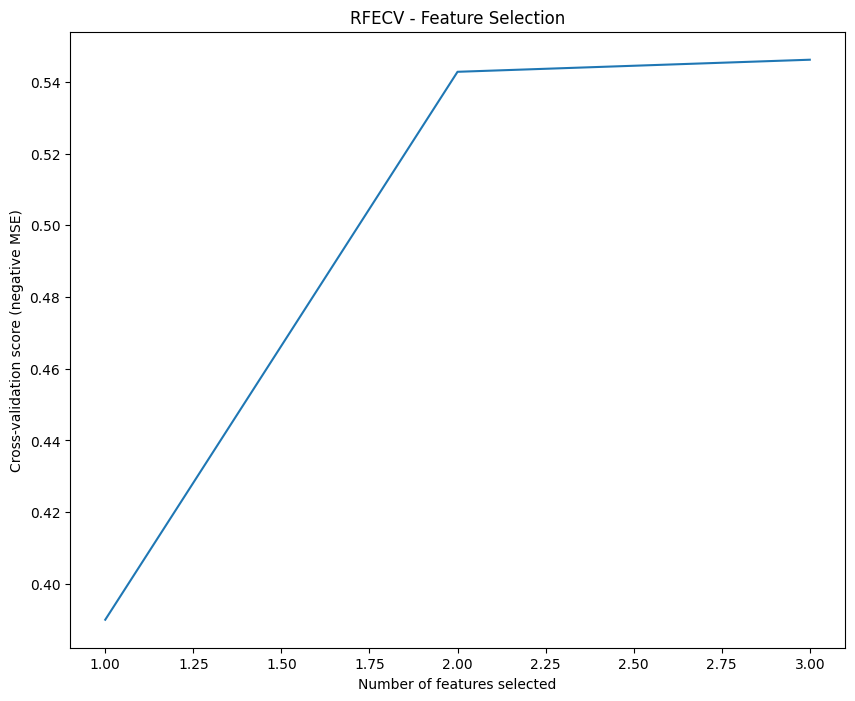

In [12]:
# Set up our X,y for target variables from our current dataframe
X = feat_fil_df.drop(columns = ['min_standard_value', 'canonical_smiles', 'morgan_fingerprints',
                                'tanimoto_mean', 'tanimoto_mean_target_mean']) # Drop everything but our target
y = feat_fil_df['min_standard_value']

# Define and set up a base model to use RFECV
model_xgb = XGBRegressor(
    n_estimators = 300,
    learning_rate = 0.05,
    max_depth = 7,
    min_child_weight = 5,
    random_state = 42,
    n_jobs=-1)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
rfecv_xgb = RFECV(estimator=model_xgb, step = 0.5, scoring = 'r2', cv = cv)

# Fit the RFECV
rfecv_xgb.fit(X,y)

# Extract the features
selected_features_xgb = X.columns[rfecv_xgb.support_]
print(f"Optimal number of features: {rfecv_xgb.n_features_}")
print(f"Selected features: {list(selected_features_xgb)}")

# Plot RFECV results
plt.figure(figsize = (10,8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (negative MSE)")
plt.title("RFECV - Feature Selection")
plt.plot(range(1, len(rfecv_xgb.cv_results_['mean_test_score']) + 1), rfecv_xgb.cv_results_['mean_test_score'])
plt.show()



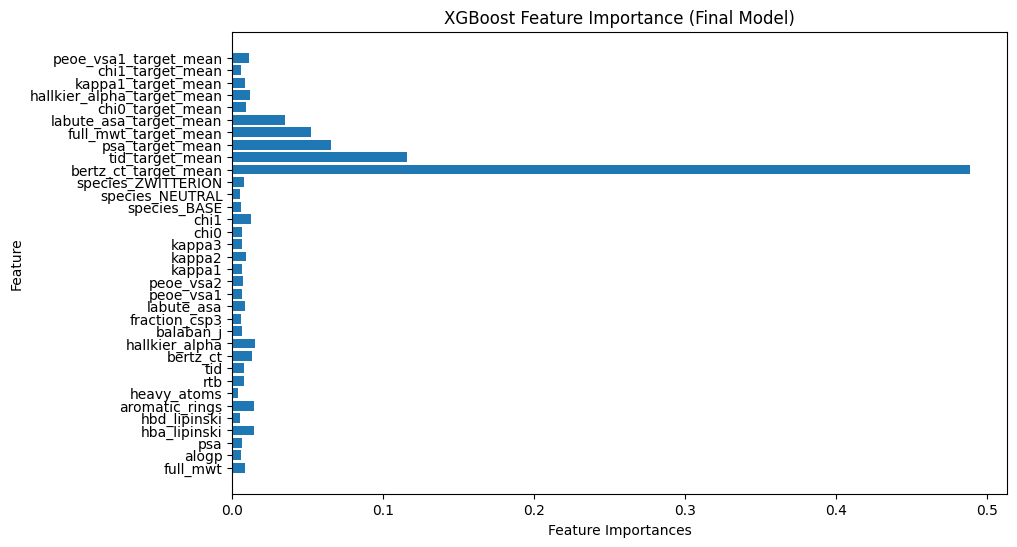

In [13]:
#Retrain the model again with the selected features without the CV
X_selected = X[selected_features_xgb].copy()
X_selected = X_selected.reset_index(drop = True)

X_selected_np = X_selected.to_numpy()

final_xgb = XGBRegressor(
    n_estimators=300,  
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=5,
    random_state=42,
    n_jobs=-1
)

final_xgb.fit(X_selected_np, y)

# Now get feature importances from this second model
importances = final_xgb.feature_importances_

# Step 3: Plot Feature Importances from the FINAL trained model
plt.figure(figsize=(10, 6))
plt.barh(X_selected.columns, importances)
plt.xlabel("Feature Importances")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance (Final Model)")
plt.show()

In [14]:
feat_fil_df.columns

Index(['canonical_smiles', 'full_mwt', 'alogp', 'psa', 'hba_lipinski',
       'hbd_lipinski', 'aromatic_rings', 'heavy_atoms', 'rtb',
       'min_standard_value', 'tid', 'bertz_ct', 'hallkier_alpha', 'balaban_j',
       'fraction_csp3', 'labute_asa', 'peoe_vsa1', 'peoe_vsa2', 'kappa1',
       'kappa2', 'kappa3', 'chi0', 'chi1', 'morgan_fingerprints',
       'tanimoto_mean', 'species_BASE', 'species_NEUTRAL',
       'species_ZWITTERION', 'tanimoto_mean_target_mean',
       'bertz_ct_target_mean', 'tid_target_mean', 'psa_target_mean',
       'full_mwt_target_mean', 'labute_asa_target_mean', 'chi0_target_mean',
       'hallkier_alpha_target_mean', 'kappa1_target_mean', 'chi1_target_mean',
       'peoe_vsa1_target_mean'],
      dtype='object')

In [15]:
# Save the top features to a new df, remembering to add back in the ones we dropped earlier.
ph1_df = feat_fil_df[['morgan_fingerprints', 'chi1_target_mean', 'min_standard_value',
                'bertz_ct_target_mean', 'tid_target_mean', 'psa_target_mean',
                'full_mwt_target_mean', 'labute_asa_target_mean', 'hba_lipinski',
                'aromatic_rings', 'hallkier_alpha', 'peoe_vsa1_target_mean'
                ]]

file_path = "/home/azureuser/cloudfiles/code/Users/kalpha1865/BioPred/Data/df_files/modeling_phase_1.parquet"
ph1_df.to_parquet(file_path, index = False)
print("Modeling phase 1 data saved as Parquet in df_files in Data folder.")

Modeling phase 1 data saved as Parquet in df_files in Data folder.


In [16]:
print(ph1_df.head())
print(ph1_df.shape)

                                 morgan_fingerprints  chi1_target_mean  \
0  0000000000000000000000000000000000000000000000...              3.06   
1  0000000000000000000000000000000000000000000000...              3.06   
2  0000000000000000000000000000000000000000000000...              3.38   
3  0000000000000000000000000000000000000000000000...              2.93   
4  0000000000000010000000000000000000000000000000...              3.01   

   min_standard_value  bertz_ct_target_mean  tid_target_mean  psa_target_mean  \
0                4.62                  3.68             3.32             3.32   
1                3.43                  3.68             3.32             3.32   
2                4.56                  4.56             3.32             3.32   
3                0.41                  3.37             3.34             2.54   
4                3.55                  1.74             3.34             2.65   

   full_mwt_target_mean  labute_asa_target_mean  hba_lipinski  aroma